In [461]:
#!g1.1
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm, tnrange

In [462]:
#!g1.1
torch.cuda.is_available()

True

In [463]:
#!g1.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
plt.rcParams['figure.dpi'] = 200

# AE Arch

In [464]:
#!g1.1
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Encoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Encoder, self).__init__()
        self.linear1 = nn.Sequential(nn.Linear(64*64*3, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [465]:
#!g1.1
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Decoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

    def forward(self, z):
        z = self.linear1(z)
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

In [466]:
#!g1.1
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

# AE Training

In [467]:
#!g1.1
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tnrange(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            opt.step()
    return autoencoder

# Date Loading

In [468]:
#!g1.1
data = torch.utils.data.DataLoader(
        torchvision.datasets.ImageFolder('custom_cartoons',
               transform=torchvision.transforms.Compose(
                   [torchvision.transforms.Resize((64,64)), 
                    torchvision.transforms.ToTensor()]),
        ),
        batch_size=32,
        shuffle=True,
        num_workers=8
)

In [469]:
#!g1.1
latent_dims = 512
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train(autoencoder, data)

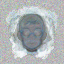

In [470]:
#!g1.1
z = torch.rand((1, 512)).to(device)
res = autoencoder.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

# VAE

In [471]:
#!g1.1
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(64*64*3, 512)
        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma*self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [472]:
#!g1.1
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [473]:
#!g1.1
def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tnrange(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [474]:
#!g1.1
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train_vae(vae, data)

In [475]:
#!g1.1
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu')

    w = 64
    img = np.zeros((w, n*w, 3))
    for i, x_hat in enumerate(interpolate_list):
        # print(x_hat.shape)
        img[:, i*w:(i+1)*w] = np.array(torchvision.transforms.ToPILImage()(x_hat)) / 255
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

In [476]:
#!g1.1
x, y = next(data.__iter__()) 
x_1 = x[0].unsqueeze(0).to(device) 
x_2 = x[1].unsqueeze(0).to(device) 

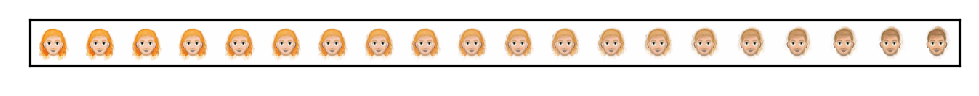

In [477]:
#!g1.1
interpolate(vae, x_1, x_2, n=20)

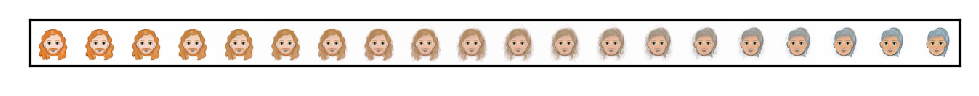

In [478]:
#!g1.1
interpolate(autoencoder, x_1, x_2, n=20)

# Compare AE and VAE Interpolations
- Which is better? 
- Why? 
- Ответ буду читац глазами, лучше подкрепить картинками и объяснениями

## Изменим архитектуру AE

Добавим Батч нормализацию

### Encoder

In [479]:
#!g1.1
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Encoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Encoder, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(64*64*3, 128), 
            nn.BatchNorm1d(128),
            nn.PReLU()
        )
        self.linear2 = nn.Sequential(
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256),
            nn.PReLU(),
        )
        self.linear3 = nn.Sequential(
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512),
            nn.PReLU()
        )
        self.linear4 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        return x

### Decoder

In [480]:
#!g1.1
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        """
            Implement Decoder Network
            You can use convolutions, or linear or whatever. 
        """
        super(Decoder, self).__init__()
        
        self.linear1 = nn.Sequential(nn.Linear(latent_dims, 512), nn.PReLU())
        self.linear2 = nn.Linear(512, 64*64*3)

    def forward(self, z):
        z = self.linear1(z)
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 3, 64, 64))

### Autoencoder

In [481]:
#!g1.1
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## AE Training

In [482]:
#!g1.1
def train(autoencoder, data, epochs=20):
    # opt = torch.optim.Adam(autoencoder.parameters())
    optimizer = torch.optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
    
    for epoch in tnrange(epochs):
        for x, y in data:
            losses = []
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(np.mean(losses))
            else:
                scheduler.step()
    return autoencoder

In [483]:
#!g1.1
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder = train(autoencoder, data)

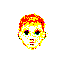

In [484]:
#!g1.1
z = torch.rand((1, 512)).to(device)
res = autoencoder.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

## VAE

### VariationalEncoder

In [485]:
#!g1.1
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        """
        Implement Variational Encoder, use whatever you want
        """
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Sequential(
            nn.Linear(64*64*3, 128), 
            nn.BatchNorm1d(128),
            nn.PReLU(),
            
            nn.Linear(128, 256), 
            nn.BatchNorm1d(256),
            nn.PReLU(),
            
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512),
            nn.PReLU()
        )
       
        self.linear2 = nn.Linear(512, latent_dims) # mu
        self.linear3 = nn.Linear(512, latent_dims) # sigma

        self.N = torch.distributions.Normal(0, 1) # psi
        self.kl = 0 # kld

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x).to(device)
        sigma = torch.exp(self.linear3(x)).to(device)
        z = mu + sigma * self.N.sample(mu.shape).to(device)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

### VariationalAutoencoder

In [486]:
#!g1.1
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

## VAE Training

In [487]:
#!g1.1
def train_vae(autoencoder, data, epochs=20):
    optimizer = torch.optim.Adam(autoencoder.parameters())
    for epoch in tnrange(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            optimizer.step()
            
    return autoencoder

In [488]:
#!g1.1
vae = VariationalAutoencoder(latent_dims).to(device) # GPU
vae = train_vae(vae, data)

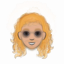

In [489]:
#!g1.1
z = torch.rand((1, 512)).to(device)
res = vae.decoder(z)
torchvision.transforms.ToPILImage()(res[0])

## Convolutional Autoencoder

In [619]:
#!g1.1
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(1568, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        #print('Encoder.forward', x.shape)
        x = self.encoder_cnn(x)
        #print('Encoder.forward.encoder_cnn', x.shape)
        x = self.flatten(x)
        #print('Encoder.forward.flatten', x.shape)
        x = self.encoder_lin(x)
        #print('Encoder.forward.encoder_lin', x.shape)
        return x

In [620]:
#!g1.1
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 1568),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 7, 7))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        #print('Decoder.forward.', x.shape)
        x = self.decoder_lin(x)
        #print('Decoder.forward.decoder_lin.', x.shape)
        x = self.unflatten(x)
        #print('Decoder.forward.unflatten.', x.shape)
        x = self.decoder_conv(x)
        #print('Decoder.forward.decoder_conv.', x.shape)
        x = torch.sigmoid(x)
        return x

In [621]:
#!g1.1
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=1568, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [625]:
#!g1.1
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        #print('image_batch', image_batch.shape)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [628]:
#!g1.1
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    #targets = test_dataset.targets.numpy()
    #t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in tnrange(n):
      ax = plt.subplot(2,n,i+1)
      #img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

In [631]:
#!g1.1
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in tnrange(num_epochs):
   train_loss = train_epoch(encoder, decoder, device, data, loss_fn, optim)
   if epoch % 5 == 0:
    print('\n EPOCH {}/{} \t train loss {}'.format(epoch + 1, num_epochs, train_loss))
   diz_loss['train_loss'].append(train_loss)
   #plot_ae_outputs(encoder, decoder, n=10)


 EPOCH 1/30 	 train loss 0.010223940946161747

 EPOCH 6/30 	 train loss 0.007217073813080788

 EPOCH 11/30 	 train loss 0.005588860251009464

 EPOCH 16/30 	 train loss 0.0047453525476157665

 EPOCH 21/30 	 train loss 0.004279273096472025

 EPOCH 26/30 	 train loss 0.0039255693554878235



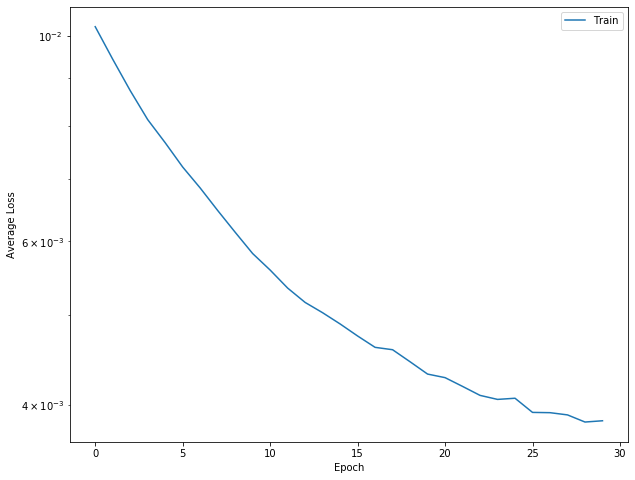

In [632]:
#!g1.1
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([ 0.0465, -0.4530,  0.0272, -0.1313])
tensor([0.5451, 0.6914, 0.7471, 0.4917])


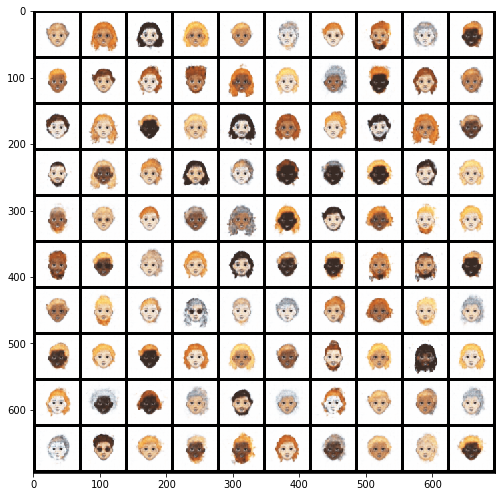

In [635]:
#!g1.1
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    images, labels = iter(data).next()
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [ ]:
#!g1.1
